# BIOS 823 - Homework 03

### Ana Belen Barcenas J.

In [1]:
%matplotlib inline

**1**. (25 points)

We have a surgeon who wants to find rich, obese patients for bariatric surgery. The surgeon purchases 3rd party databases that include the following:

- patients - includes height and weight for 100 patients
- finances - income of patients
- orders - patients who have bought weight loss products before

We want to help the surgeon find his potential patients. Her criteria are

- patient must be obese with BMI (weight (kg) / (height (m) * height (m))
- patient must be rich - income > $100,000
- patient must have bought weight loss products previously

Find the patient names, bmi and income for those meeting the 3 criteria using

- EQUIJOIN (no subqueries)
- INNER JOIN (no subqueries)
- Subqueries
- Common table expressions
- Views

In [1]:
from faker import Faker
import numpy as np
import pandas as pd

In [2]:
np.random.seed(123)

fake = Faker()
names = [fake.name() for i in range(100)]
hts = np.random.normal(1.7, 0.1, 100)
wts = np.random.normal(85, 10, 100)
patients = pd.DataFrame(dict(name=names, wt=wts, ht=hts))
patients.index.name = 'patient_id'

incomes = np.random.np.random.lognormal(11, 1, 100).astype('int')
finances = pd.DataFrame(dict(income=incomes, patient_id=np.random.permutation(100)))
finances.index.name = 'finance_id'

order_total = np.random.randint(100, 100000, 200)
patient_ids = np.random.randint(0, 500, 200)
orders = pd.DataFrame(dict(sales=order_total, patient_id=patient_ids))
orders.index.name = 'order_id'

In [3]:
%load_ext sql
%sql sqlite://

'Connected: @None'

In [4]:
%sql DROP TABLE IF EXISTS patients
%sql DROP TABLE IF EXISTS finances
%sql DROP TABLE IF EXISTS orders

%sql PERSIST patients
%sql PERSIST finances
%sql PERSIST orders

 * sqlite://
Done.
 * sqlite://
Done.
 * sqlite://
Done.
 * sqlite://
 * sqlite://
 * sqlite://


'Persisted orders'

Using EQUIJOIN

In [6]:
%%sql

SELECT DISTINCT p.name, (wt/(ht*ht)) as bmi, income
FROM patients as p,  finances as f, orders as o
WHERE p.patient_id=f.patient_id and p.patient_id=o.patient_id 
and f.income>100000 
and (wt/(ht*ht))>=30 
and sales>0

 * sqlite://
Done.


name,bmi,income
Andrea Johnson,37.000788993952455,119168
Christine Russo,33.4063128740601,244842


Using INNER JOIN

In [7]:
%%sql

SELECT DISTINCT name, (wt/(ht*ht)) as bmi, income 
FROM (patients p 
      INNER JOIN orders o ON p.patient_id=o.patient_id
      INNER JOIN finances f ON p.patient_id=f.patient_id)
WHERE (wt/(ht*ht))>=30 and income>100000

 * sqlite://
Done.


name,bmi,income
Andrea Johnson,37.000788993952455,119168
Christine Russo,33.4063128740601,244842


Using subtable.

In [8]:
%%sql

SELECT DISTINCT p.name, (wt/(ht*ht)) as bmi, f.income
FROM patients p, finances f 
WHERE 

bmi>30 AND income>100000 AND p.patient_id=f.patient_id

AND p.patient_id in
(
    SELECT distinct patient_id
    FROM orders
)  



 * sqlite://
Done.


name,bmi,income
Andrea Johnson,37.000788993952455,119168
Christine Russo,33.4063128740601,244842


Using CTE

In [9]:
%%sql

WITH common AS (
    SELECT DISTINCT
        patients.name,
        (patients.wt/(patients.ht*patients.ht)) as bmi,
        finances.income
    
    FROM 
        orders,
        patients,
        finances
    
    WHERE patients.patient_id IN
        (SELECT DISTINCT patient_id FROM orders)
    AND patients.patient_id=finances.patient_id
)

SELECT DISTINCT *
FROM common
WHERE bmi>30 and income>100000

 * sqlite://
Done.


name,bmi,income
Christine Russo,33.4063128740601,244842
Andrea Johnson,37.000788993952455,119168


Using views.

In [12]:
%%sql

CREATE VIEW view_common_ AS 
    SELECT DISTINCT
        patients.name,
        (patients.wt/(patients.ht*patients.ht)) as bmi,
        finances.income
    FROM 
        orders,
        patients,
        finances
    
    WHERE patients.patient_id IN
        (SELECT DISTINCT patient_id FROM orders)
        
    AND patients.patient_id=finances.patient_id


 * sqlite://
Done.


[]

In [13]:
%%sql

SELECT DISTINCT *
FROM view_common_
WHERE bmi>30 and income>100000

 * sqlite://
Done.


name,bmi,income
Christine Russo,33.4063128740601,244842
Andrea Johnson,37.000788993952455,119168


**2**. (25 points)

Use windows functions in SQL to achieve the same effect as these `pandas` operations.`m

In [14]:
url = 'https://raw.githubusercontent.com/statsmodels/statsmodels/master/statsmodels/datasets/nile/nile.csv'
nile = pd.read_csv(url, index_col=0)

In [15]:
%sql PERSIST nile

 * sqlite://


'Persisted nile'

In [16]:
nile.shape

(100, 1)

In [17]:
nile.head(10)

,volume
year,
1871,1120
1872,1160
1873,963
1874,1210
1875,1160
1876,1160
1877,813
1878,1230
1879,1370


In [18]:
a1 = nile.rolling(5, min_periods=1).mean()
a1.head(6)

,volume
year,
1871,1120.00
1872,1140.00
1873,1081.00
1874,1113.25
1875,1122.60
1876,1130.60


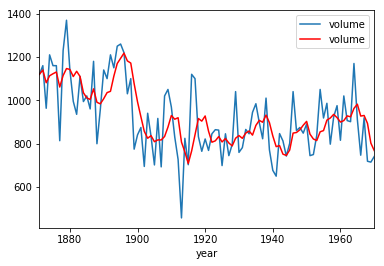

In [19]:
ax = nile.plot()
a1.plot(color='red', ax=ax)
pass

SQL solution here

In [20]:
%%sql

SELECT year, AVG(volume) OVER win AS volume_avg
FROM nile
WINDOW win AS (
    ORDER BY year ASC
    ROWS BETWEEN 4 PRECEDING AND 0 FOLLOWING)
LIMIT 6

 * sqlite://
Done.


year,volume_avg
1871,1120.0
1872,1140.0
1873,1081.0
1874,1113.25
1875,1122.6
1876,1130.6


In [21]:
a2 = nile.rolling(5, center=True, min_periods=1).mean()
a2.head(6)

,volume
year,
1871,1081.00
1872,1113.25
1873,1122.60
1874,1130.60
1875,1061.20
1876,1114.60


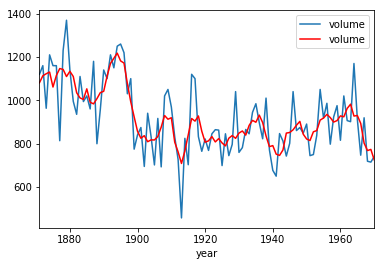

In [22]:
ax = nile.plot()
a2.plot(color='red', ax=ax)
pass

SQL solution here

In [23]:
%%sql

SELECT year, AVG(volume) OVER win AS volume_avg
FROM nile
WINDOW win AS (
    ORDER BY year ASC
    ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
LIMIT 6

 * sqlite://
Done.


year,volume_avg
1871,1081.0
1872,1113.25
1873,1122.6
1874,1130.6
1875,1061.2
1876,1114.6


In [24]:
a3 = nile.expanding().mean()
a3.head(6)

,volume
year,
1871,1120.000000
1872,1140.000000
1873,1081.000000
1874,1113.250000
1875,1122.600000
1876,1128.833333


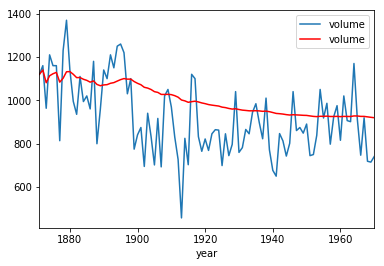

In [25]:
ax = nile.plot()
a3.plot(color='red', ax=ax)
pass

SQL solution here

In [26]:
%%sql

SELECT year, AVG(volume) OVER win AS volume_avg
FROM nile
WINDOW win AS (
    ORDER BY year ASC
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
LIMIT 6

 * sqlite://
Done.


year,volume_avg
1871,1120.0
1872,1140.0
1873,1081.0
1874,1113.25
1875,1122.6
1876,1128.8333333333333


In [27]:
a4 = nile.rank(method='dense').sort_values('volume')
a4.head(6)

,volume
year,
1913,1.0
1941,2.0
1940,3.0
1907,4.0
1902,5.0
1925,6.0


SQL solution here

In [28]:
%%sql

SELECT year, RANK() OVER win AS volume_rank
FROM nile
WINDOW win AS (
    ORDER BY volume)
LIMIT 6

 * sqlite://
Done.


year,volume_rank
1913,1
1941,2
1940,3
1907,4
1902,5
1925,6


In [29]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [30]:
quartiles = pd.qcut(nile.volume, 
            np.linspace(0,1,5), 
            labels=['Q1', 'Q2', 'Q3', 'Q4'])
quartiles.name = 'quartile'
#print(quartiles)
#print(type(quartiles))
df = pd.concat([nile, quartiles], axis=1)
#print(df)

In [31]:
df.groupby('quartile').sum()

,volume
quartile,
Q1,18101
Q2,20999
Q3,23995
Q4,28840


SQL solution here

In [32]:
%%sql

SELECT DISTINCT quartile, SUM(volume) as sum_volume
FROM (
SELECT volume, NTILE(4)
OVER (
    ORDER BY volume 
) AS quartile
FROM nile
)
GROUP BY quartile

 * sqlite://
Done.


quartile,sum_volume
1,18101
2,20999
3,23995
4,28840


**3**. (50 points)

Convert the flat file data in `h04q03.csv` into a well-structured relational database (i.e. at least in 3NF) in SQLite3 as `ho4q03.db`. Note - salary information is confidential and should be kept in a separate table from other personal data.

- Use only `pandas` operations.
- Do not make use of SQL line or cell magic

In [5]:
import pandas as pd
import numpy as np
import random
import pandas_explode 
#import explode

df = pd.read_csv('h04q03.csv')
df.head()

,name,gender,age,height,weight,salary,nationality,code,country,language1,language2,language3,first,last
0,Aaron Alexander,Male,54,1.70,90,151000,British,GB,United Kingdom,Haskell,NaN,NaN,Aaron,Alexander
1,Aaron Kirby,Male,59,1.69,43,80000,Spanish,SP,Spain,Falcon,haXe,GNU Octave,Aaron,Kirby
2,Abram Allen,Male,41,1.70,44,75000,Italian,IT,Italy,TypeScript,NaN,NaN,Abram,Allen
3,Abram Boyer,Male,45,1.64,68,76000,Italian,IT,Italy,Lua,Falcon,Io,Abram,Boyer
4,Adaline Barry,Female,54,1.87,58,122000,Uruguayan,UY,Uruguay,Racket,NaN,NaN,Adaline,Barry


In [6]:
df.columns

Index(['name', 'gender', 'age', 'height', 'weight', 'salary', 'nationality',
       'code', 'country', 'language1', 'language2', 'language3', 'first',
       'last'],
      dtype='object')

1) We'll create a table including only languages and the complete name as the primary key. 


In [35]:
# No repeting columns
df_1 = pd.melt(df[['name','language1','language2','language3']], 
              id_vars=['name'], 
             var_name='language_num', 
             value_name='language')

df_1.language_num = df_1.language_num.str.extract('.*(\d+)$')

# Drop duplicates (if any)
df_1.drop_duplicates()

df_1.head()

,name,language_num,language
0,Aaron Alexander,1,Haskell
1,Aaron Kirby,1,Falcon
2,Abram Allen,1,TypeScript
3,Abram Boyer,1,Lua
4,Adaline Barry,1,Racket


2) Now, I'll create a table including only name and the salary since it is confidential information

In [36]:
# Keep only the salary information and the primary key "name"

df_2 = df[['name','salary']]

# Drop duplicates (if any)
df_2.drop_duplicates()

df_2.head()

,name,salary
0,Aaron Alexander,151000
1,Aaron Kirby,80000
2,Abram Allen,75000
3,Abram Boyer,76000
4,Adaline Barry,122000


3) Now, to avoid codependencies I will create a table that includes only name, nationality, code, and country since code and country depends solely on the nationality.

In [37]:
df_3 = df[['name', 'nationality', 'code', 'country']]

# Drop duplicates (if any)
df_3.drop_duplicates()

df_3.head()

,name,nationality,code,country
0,Aaron Alexander,British,GB,United Kingdom
1,Aaron Kirby,Spanish,SP,Spain
2,Abram Allen,Italian,IT,Italy
3,Abram Boyer,Italian,IT,Italy
4,Adaline Barry,Uruguayan,UY,Uruguay


4) Finally, I will create a table with the rest of the variables except last and first name split in two different to avoid repetition. All tables have "name" as the primary key.

In [38]:
df_4 = df[['name', 'gender', 'age', 'height', 'weight']]

# Drop duplicates (if any)
df_4.drop_duplicates()
df_4.head()

,name,gender,age,height,weight
0,Aaron Alexander,Male,54,1.70,90
1,Aaron Kirby,Male,59,1.69,43
2,Abram Allen,Male,41,1.70,44
3,Abram Boyer,Male,45,1.64,68
4,Adaline Barry,Female,54,1.87,58


In [39]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///ho4q03.db', echo=False)

df_1.to_sql('df_1',if_exists='replace', con=engine)
df_2.to_sql('df_2',if_exists='replace', con=engine)
df_3.to_sql('df_3',if_exists='replace', con=engine)
df_4.to_sql('df_4',if_exists='replace', con=engine)